In [3]:
import numpy as np

## Functions

In [5]:
def sigmoid(z):
    """ Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
        """Derivative of the sigmoid function."""
        return sigmoid(z) * (1 - sigmoid(z))

def mse(y_pred, y):
    """Mean Squared Error (MSE) cost function."""
    return np.mean((y_pred - y) ** 2)

def mse_prime(y_pred, y):
    """Derivative of the Mean Squared Error (MSE) cost function."""
    return 2 * (y_pred - y) / y.shape[1]
    
def softmax(z):
    """Softmax function: Converts input values into probabilities""" 
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def softmax_prime(z):
    """Derivative of softmax"""
    s = softmax(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_prime(z):
    """Derivative of the ReLU function."""
    return (z > 0).astype(float)

def leaky_relu(z, a=0.01):
    """Leaky ReLU activation function."""
    return np.maximum(a * z, z)

def leaky_relu_prime(z, a=0.01):
    """Derivative of the Leaky ReLU function."""
    dz = np.ones_like(z)
    dz[z <= 0] = a
    return dz

def cross_entropy(y_pred, y):
    """Cross-entropy loss function."""
    m = y.shape[1]
    return -np.sum(y * np.log(y_pred + 1e-9)) / m

def cross_entropy_prime(y_pred, y):
    """Derivative of the cross-entropy loss with respect to the softmax input."""
    return y_pred - y

## Neural network class

In [7]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, activations, cost):
        """
        Initialize the neural network with random weights and biases.
        
        Args:
            layer_sizes (list): List of integers specifying the number of neurons in each layer.
                               Example: [input_size, hidden_size, ..., output_size]
            activations (list): List of tuples (activation_func, activation_prime) for each layer after the input.
            cost (tuple): Tuple (cost_func, cost_prime) for the cost function and its derivative.
        """
        self.layer_sizes = layer_sizes
        self.activations = activations  # Each element is a tuple (activation_func, activation_prime)
        self.cost = cost  # Tuple (cost_func, cost_prime)
        
        # Validate input
        if len(activations) != len(layer_sizes) - 1:
            raise ValueError("Number of activations must match the number of layers (excluding input).")
        
        # Initialize weights and biases
        self.weights = [np.random.randn(y, x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        
        
    def forward(self, X):
        # Reshape input to a column vector
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.a = [X]  # List to store activations for each layer
        self.z = []   # List to store weighted inputs for each layer

        for l, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = w @ self.a[-1] + b  # Weighted input
            self.z.append(z)
            
            a_func = self.activations[l][0]
            a = a_func(z)
            self.a.append(a)
        
        return self.a[-1]
        
    
    def backprop(self, y):
        """
        Compute gradients using backpropagation.
        
        Args:
            y: Target outputs of shape (output_size, batch_size).
        
        Returns:
            Tuple (grad_w, grad_b) containing gradients for each layer.
        """
        # Initialize gradient lists
        grad_w = [np.zeros_like(w) for w in self.weights]
        grad_b = [np.zeros_like(b) for b in self.biases]
        
        cost_prime = self.cost[1] # Dericative of the cost function
        a_prime = self.activations[-1][1] # Activation function of the last layer
        
        # Compute output layer error (delta)
        delta = cost_prime(self.a[-1], y) * a_prime(self.z[-1]) 
        # Store output layer gradients
        grad_w[-1] = delta @ self.a[-2].T
        grad_b[-1] = delta
        
        # Backpropagate through hidden layers
        for l in reversed(range(len(self.weights) - 1)):
            a_prime = self.activations[l][1]
            # Calculate delta for current layer
            delta = (self.weights[l+1].T @ delta) * a_prime(self.z[l])
            # Compute gradients
            grad_w[l] = delta @ self.a[l].T
            grad_b[l] = delta
        
        return grad_w, grad_b
        
    
    def update_parameters(self, grad_w, grad_b, eta, batch_size):
        """Update weights and biases using averaged gradients."""
        for l in range(len(self.weights)):
            self.weights[l] -= eta * (grad_w[l] / batch_size)
            self.biases[l] -= eta * (grad_b[l] / batch_size)
            
    
    def train(self, x_train, y_train, epochs, batch_size, eta, results=False):
        """
        Train the network using mini-batch SGD.
        
        Args:
            x_train: Input data of shape (num_samples, input_size).
            y_train: Target outputs of shape (num_samples, output_size).
            epochs: Number of training epochs.
            batch_size: Size of mini-batches.
            eta: Learning rate.
        """
        num_samples = len(x_train)
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            X_shuffled = [x_train[i] for i in indices]
            y_shuffled = [y_train[i] for i in indices]

            epoch_outputs = []
            epoch_labels = []
            
            # Process mini-batches
            for i in range(0, num_samples, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Initialize gradient arrays
                grad_w = [np.zeros_like(w) for w in self.weights]
                grad_b = [np.zeros_like(b) for b in self.biases]
                
                # Accumulate gradients over batch
                for x, y_true in zip(X_batch, y_batch):
                    # Convert to column vectors
                    x = x.reshape(-1, 1)
                    y_true = y_true.reshape(-1, 1)

                    # Forward + Backprop
                    output = self.forward(x)
                    batch_grad_w, batch_grad_b = self.backprop(y_true)

                    if results:
                        epoch_outputs.append(output.flatten())  # Save output
                        epoch_labels.append(y_true.flatten())  # Save true label
                    
                    # Accumulate gradients
                    for l in range(len(self.weights)):
                        grad_w[l] += batch_grad_w[l]
                        grad_b[l] += batch_grad_b[l]
                
                # Update parameters
                self.update_parameters(grad_w, grad_b, eta, batch_size)
                
            
            # Print epoch results
            if results and epoch_outputs:
                epoch_outputs = np.array(epoch_outputs)
                epoch_labels = np.array(epoch_labels)
                
                loss = self.cost[0](epoch_outputs, epoch_labels)
                # Calculate accuracy
                predictions = np.argmax(epoch_outputs, axis=1)
                true_labels = np.argmax(epoch_labels, axis=1)
                accuracy = np.mean(predictions == true_labels)

                # Print results
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
                

## Training

### Load MNIST dataset and seperate test and train data

In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images (28x28 -> 784)
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### Initialize neural network and train it

In [12]:
layer_sizes = [784, 128, 64, 10]
activations = [
        (relu, relu_prime), 
        (relu, relu_prime),
        (softmax, softmax_prime)
    ]
cost = (cross_entropy, cross_entropy_prime)

nn = NeuralNetwork(layer_sizes, activations, cost)

# He initialization for ReLU
nn.weights = [np.random.randn(y, x) * np.sqrt(2 / x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]

epochs = 30
batch_size = 64
eta = 0.5

nn.train(x_train, y_train, epochs, batch_size, eta, results=True)

Epoch 1/30, Loss: 2618.3984, Accuracy: 87.22%
Epoch 2/30, Loss: 1262.4327, Accuracy: 94.16%
Epoch 3/30, Loss: 957.7964, Accuracy: 95.62%
Epoch 4/30, Loss: 783.9296, Accuracy: 96.48%
Epoch 5/30, Loss: 674.2637, Accuracy: 97.02%
Epoch 6/30, Loss: 584.2509, Accuracy: 97.51%
Epoch 7/30, Loss: 518.9466, Accuracy: 97.77%
Epoch 8/30, Loss: 466.9037, Accuracy: 98.03%
Epoch 9/30, Loss: 423.9601, Accuracy: 98.20%
Epoch 10/30, Loss: 382.9063, Accuracy: 98.45%
Epoch 11/30, Loss: 356.9478, Accuracy: 98.61%
Epoch 12/30, Loss: 331.1747, Accuracy: 98.72%
Epoch 13/30, Loss: 312.0090, Accuracy: 98.84%
Epoch 14/30, Loss: 287.1173, Accuracy: 98.95%
Epoch 15/30, Loss: 268.6574, Accuracy: 99.05%
Epoch 16/30, Loss: 253.2392, Accuracy: 99.10%
Epoch 17/30, Loss: 239.8244, Accuracy: 99.19%
Epoch 18/30, Loss: 223.4015, Accuracy: 99.25%
Epoch 19/30, Loss: 217.2382, Accuracy: 99.29%
Epoch 20/30, Loss: 210.1030, Accuracy: 99.33%
Epoch 21/30, Loss: 191.6991, Accuracy: 99.43%
Epoch 22/30, Loss: 189.8896, Accuracy: 99

## Testing

Accuracy: 97.61% (9761/10000)

Correctly Classified Examples:
Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00]


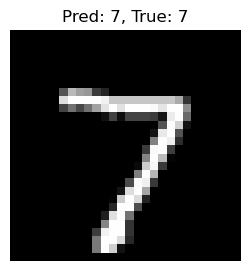


Network output: 
[0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


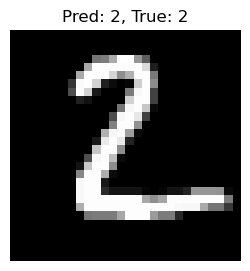


Network output: 
[0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


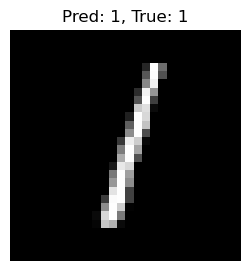


Network output: 
[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


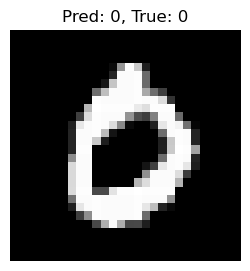


Network output: 
[0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00]


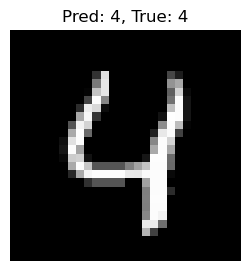




Misclassified Examples:
Network output: 
[0.00, 0.34, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.66]


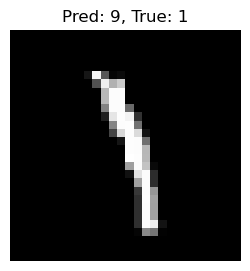


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.58, 0.00, 0.00, 0.00, 0.42]


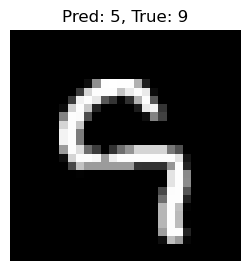


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.03, 0.00, 0.00, 0.00, 0.00, 0.97]


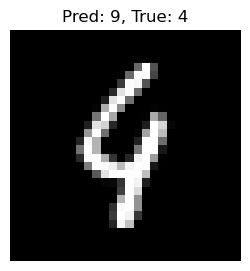


Network output: 
[0.00, 0.01, 0.21, 0.11, 0.01, 0.03, 0.00, 0.00, 0.56, 0.08]


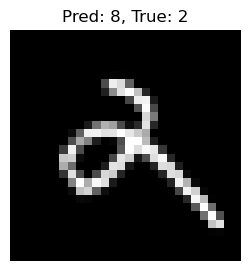


Network output: 
[0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


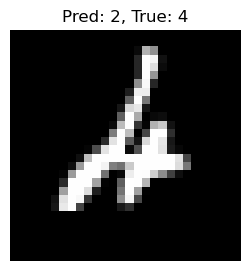


Network output: 
[0.70, 0.00, 0.00, 0.00, 0.00, 0.00, 0.30, 0.00, 0.00, 0.00]


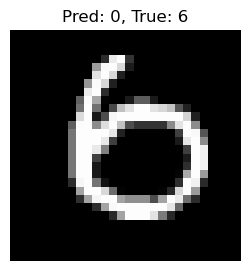


Network output: 
[0.00, 0.00, 0.00, 0.93, 0.00, 0.00, 0.00, 0.02, 0.00, 0.05]


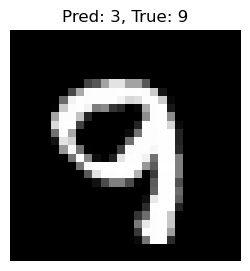


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00]


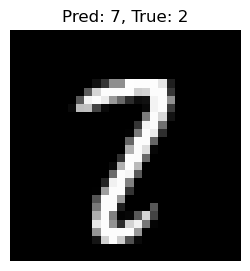


Network output: 
[0.00, 0.00, 0.00, 0.96, 0.00, 0.04, 0.00, 0.00, 0.00, 0.00]


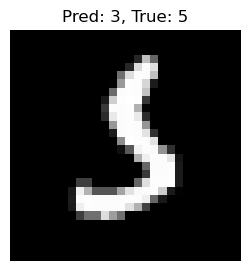


Network output: 
[0.00, 0.00, 0.00, 0.03, 0.00, 0.00, 0.00, 0.97, 0.00, 0.00]


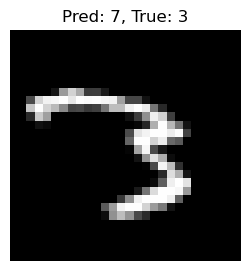


Network output: 
[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


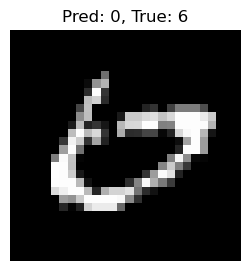


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.98]


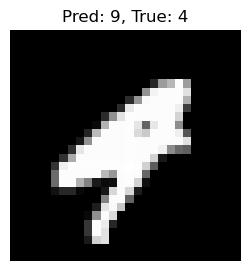


Network output: 
[0.79, 0.00, 0.20, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


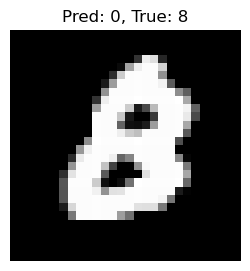


Network output: 
[0.00, 0.00, 0.74, 0.01, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00]


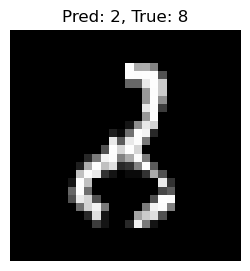


Network output: 
[0.00, 0.07, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.93, 0.00]


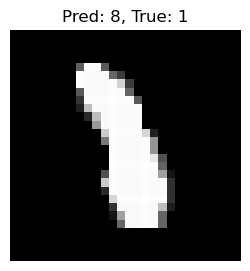


Network output: 
[0.00, 0.93, 0.04, 0.00, 0.00, 0.00, 0.00, 0.03, 0.00, 0.00]


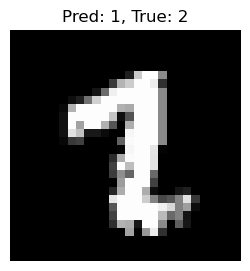


Network output: 
[0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00]


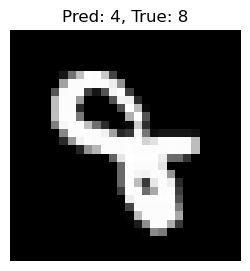


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.19, 0.00, 0.00, 0.81, 0.00]


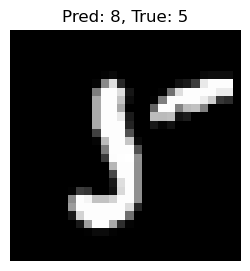


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00, 0.00, 0.89]


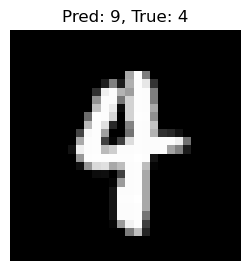


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00]


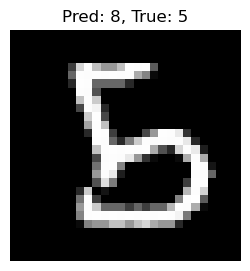


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.14, 0.00, 0.00, 0.00, 0.00, 0.86]


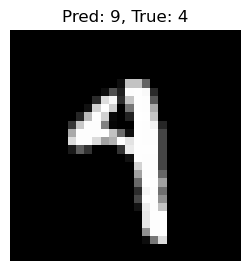


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.30, 0.00, 0.00, 0.00, 0.00, 0.70]


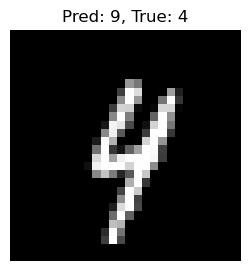


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.99, 0.01]


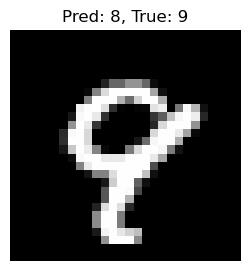


Network output: 
[0.00, 0.00, 0.00, 0.81, 0.00, 0.00, 0.00, 0.00, 0.19, 0.00]


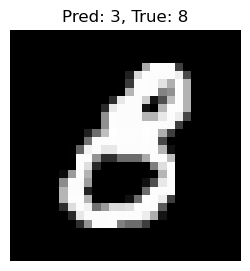


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.93, 0.00, 0.07]


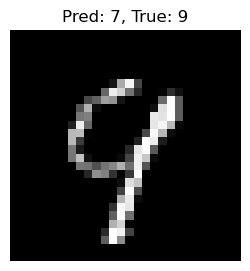

In [14]:
import matplotlib.pyplot as plt

def test_model(network, X_test, y_test, num_correct=5, num_false=5, show_examples=True):
    # Convert labels and initialize storage
    true_labels = np.argmax(y_test, axis=1)
    correct, misclassified = [], []
    all_outputs = []
    
    # Single pass through all test data
    for i in range(len(X_test)):
        x = X_test[i].reshape(-1, 1)  # Network expects column vector
        output = network.forward(x).flatten()
        pred = np.argmax(output)
        actual = true_labels[i]
        
        # Store outputs and sort examples
        all_outputs.append(output)
        if pred == actual:
            correct.append(i)
        else:
            misclassified.append(i)
    
    # Calculate and print accuracy
    accuracy = len(correct) / len(X_test)
    print(f"Accuracy: {accuracy * 100:.2f}% ({len(correct)}/{len(X_test)})")

    if not show_examples:
        return
    
    # Helper function to show examples
    def show_examples(examples, title, num_examples):
        print(f"\n{title}:")
        for i in examples[:num_examples]:
            x = X_test[i]
            output = all_outputs[i]
            pred = np.argmax(output)
            true = true_labels[i]

            print("Network output: ")
            print(f"[{', '.join(f'{v:.2f}' for v in output)}]")
            plt.figure(figsize=(3, 3))
            plt.imshow(x.reshape(28, 28), cmap='gray')
            plt.title(f"Pred: {pred}, True: {true}")
            plt.axis('off')
            plt.show()
            print()

        print("=" * 60)
        print()
    
    # Show both correct and misclassified examples
    if correct:
        show_examples(correct, "Correctly Classified Examples", num_correct)
    if misclassified:
        show_examples(misclassified, "Misclassified Examples", num_false)
        

test_model(nn, x_test, y_test, num_correct=5, num_false=25)